# **Analyzing COVID-19 cases in NYC**

In March 2020, WHO declared COVID-19 outbreak a global pandemic. Since then, this virus has spread rapidly and affected more than 4 million people; while it has taken the lives of nearly 290,000 people worldwide (as of May 9, 2020). New York City is among one the most severely affected cities in the world, which accounts for nearly 50% of confirmed cases in the U.S. 

In this notebook, we will examine the relationship between number of COVID-19 confirmed cases with median income per zip code in New York City (NYC).

## Data Sources

-  tests-by-zcta.txt: file about the number of tests given and the number of positive cases in each zip code in NYC
-  Income 2018.csv: file about the median income in each zip code in NYC
-  population_zip_code.xlsx: file about the population in each zip code in NYC

## 1 Installing packages

In [1]:
!pip install geopandas
!pip install descartes
!pip install matplotlib
!pip install numpy
!pip install pandas

     |████████████████████████████████| 931kB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 10.9MB 23kB/s  eta 0:00:01
     |████████████████████████████████| 1.8MB 3.3MB/s eta 0:00:01
     |████████████████████████████████| 14.7MB 6.0kB/s ta 0:00:014��██████████████████████▊        | 10.9MB 25kB/s eta 0:02:29�██████▌      | 11.7MB 224kB/s eta 0:00:14
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Import libraries

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

%matplotlib inline

## 2 Loading and Wrangling Data

We start with loading data from each file.

### Loading and Wrangling 'Test' Data

In [64]:
df_test = pd.read_csv ('tests-by-zcta.txt', delimiter =',')
df_test.head()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
0,NaN,5278,5607,94.13
1,10001.0,321,1130,28.41
2,10002.0,931,2457,37.89
3,10003.0,414,1549,26.73
4,10004.0,28,108,25.93


In [65]:
print('Data shape: ', df_test.shape)

Data shape:  (178, 4)


The 'test' table has 4 columns and 178 rows in total. The first row appears to be a total cases of each column. 

In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 4 columns):
MODZCTA              177 non-null float64
Positive             178 non-null int64
Total                178 non-null int64
zcta_cum.perc_pos    178 non-null float64
dtypes: float64(2), int64(2)
memory usage: 5.6 KB


In [67]:
df_test.describe()

,MODZCTA,Positive,Total,zcta_cum.perc_pos
count,177.000000,178.000000,178.000000,178.000000
mean,10810.378531,1033.140449,2567.764045,37.876461
std,578.173317,783.464829,1624.879323,8.224601
min,10001.000000,23.000000,108.000000,19.520000
25%,10301.000000,478.000000,1281.750000,33.840000
50%,11109.000000,833.000000,2151.000000,38.660000
75%,11361.000000,1439.000000,3736.500000,42.317500
max,11697.000000,5278.000000,7588.000000,94.130000


There is no missing data after the first row in this table. The statisitcs shows that there might be outliers in variable 'Positive' and 'Total'.

In [6]:
df_test = df_test.drop([0])
df_test = df_test.rename(columns={'MODZCTA': 'Zip_Code', 'zcta_cum.perc_pos': 'Positive_Rate'})
print(df_test.head(10))

    Zip_Code  Positive  Total  Positive_Rate
1    10001.0       321   1130          28.41
2    10002.0       931   2457          37.89
3    10003.0       414   1549          26.73
4    10004.0        28    108          25.93
5    10005.0        54    256          21.09
6    10006.0        23    108          21.30
7    10007.0        48    244          19.67
8    10009.0       631   2105          29.98
9    10010.0       242   1171          20.67
10   10011.0       478   1606          29.76


For data wrangling, we remove the first row of this dataframe to eliminate the missing record. Then, we will give meaningful name for the following variables 'MODZCTA' as 'Zip_Code', 'zcta_cum.perc_pos' as 'Positive_Rate'.

### Loading 'Income' Data

In [7]:
df_income = pd.read_csv ('Income 2018.csv')
df_income.head()

,geoid,Zip_Code,Median_Income
0,86000US07421,7421,92274
1,86000US10001,10001,88526
2,86000US10002,10002,35859
3,86000US10003,10003,112131
4,86000US10004,10004,157645


In [8]:
print('Data shape: ', df_income.shape)

Data shape:  (1646, 3)


The 'Income 2018' table has 3 columns and 1646 rows in total. 

In [9]:
df_income.info()
df_income.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646 entries, 0 to 1645
Data columns (total 3 columns):
geoid            1646 non-null object
Zip_Code         1646 non-null int64
Median_Income    1646 non-null int64
dtypes: int64(2), object(1)
memory usage: 38.7+ KB


,Zip_Code,Median_Income
count,1646.000000,1646.000000
mean,12746.985419,70733.653098
std,1325.165010,31242.076564
min,7421.000000,15089.000000
25%,11771.250000,51173.750000
50%,12837.500000,61690.500000
75%,13783.750000,82067.250000
max,14905.000000,250001.000000


There is no missing data in this table. There might be outliers in Median_Income variables. A quick glance of this data shows us an income inequality between neighborhood in NYC.

### Loading and Wrangling Population Data

In [10]:
df = pd.read_excel ('population_zip_code.xlsx')
df.tail(10)

,Rank,Zip Code,Population
1595,"1,596 TIE",12811 and 12490,28
1596,1597,13860,26
1597,1598,12911,25
1598,1599,12864,24
1599,1600,14112,18
1600,1601,13475,16
1601,1602,13826,15
1602,"1,603 TIE",14854 and 13623,13
1603,1604,13353,10
1604,1605,12862,5


In [69]:
print('Data shape: ', df.shape)

Data shape:  (1605, 3)


The 'population_zip_code' table has 3 columns and 1605 rows in total. Some rows contains mulitple zip codes in a record.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1605 entries, 0 to 1604
Data columns (total 3 columns):
Rank          1605 non-null object
Zip Code      1605 non-null object
Population    1605 non-null int64
dtypes: int64(1), object(2)
memory usage: 37.7+ KB


In [70]:
df.describe()

,Population
count,1605.000000
mean,12082.482243
std,18437.899284
min,5.000000
25%,1162.000000
50%,3815.000000
75%,14915.000000
max,112425.000000


#### Data Wrangling

In [12]:
# Create dataframe with "Rank" has no tie
df_tie = df[~df.Rank.str.contains("TIE", na=False)]
df_tie.sample(5)

,Rank,Zip Code,Population
119,120,14609,42042
647,648,14706,6189
1528,1529,12139,156
1562,1563,10953,96
171,172,11369,34118


In [13]:
df_tie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1604
Data columns (total 3 columns):
Rank          1472 non-null object
Zip Code      1472 non-null object
Population    1472 non-null int64
dtypes: int64(1), object(2)
memory usage: 46.0+ KB


In [14]:
#Replace "and" in Zip Code in Population table
df["Zip Code"]= df["Zip Code"].replace("and", ",", regex=True)

In [15]:
#Split columns with "," into multiple rows
df_split = df.set_index(['Rank']).stack().str.split('/|, ,|,', expand=True).stack().unstack(-2).reset_index(-1, drop=True).reset_index()
df_split.tail(10)

,Rank,Zip Code
271,"1,591 TIE",12436
272,"1,591 TIE",12922
273,"1,595 TIE",12438
274,"1,595 TIE",13352
275,"1,595 TIE",14168
276,"1,595 TIE",13102
277,"1,596 TIE",12811
278,"1,596 TIE",12490
279,"1,603 TIE",14854
280,"1,603 TIE",13623


In [16]:
df_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
Rank        281 non-null object
Zip Code    281 non-null object
dtypes: object(2)
memory usage: 4.5+ KB


In [17]:
#Merge split dataframe with population table to get population variables
df_split_population = pd.merge(df, df_split, on="Rank", how = "left")
df_split_population = df_split_population.dropna()
df_split_population.tail(10)

,Rank,Zip Code_x,Population,Zip Code_y
1732,"1,591 TIE","12436 , 12922",39,12436
1733,"1,591 TIE","12436 , 12922",39,12922
1737,"1,595 TIE","12438, 13352, 14168, , 13102",32,12438
1738,"1,595 TIE","12438, 13352, 14168, , 13102",32,13352
1739,"1,595 TIE","12438, 13352, 14168, , 13102",32,14168
1740,"1,595 TIE","12438, 13352, 14168, , 13102",32,13102
1741,"1,596 TIE","12811 , 12490",28,12811
1742,"1,596 TIE","12811 , 12490",28,12490
1749,"1,603 TIE","14854 , 13623",13,14854
1750,"1,603 TIE","14854 , 13623",13,13623


In [18]:
df_split_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281 entries, 297 to 1750
Data columns (total 4 columns):
Rank          281 non-null object
Zip Code_x    281 non-null object
Population    281 non-null int64
Zip Code_y    281 non-null object
dtypes: int64(1), object(3)
memory usage: 11.0+ KB


In [19]:
df_split_population = df_split_population.drop(['Zip Code_x'], axis=1)

In [20]:
df_split_population.sample(10)

,Rank,Population,Zip Code_y
1573,"1,471 TIE",276,14742
1004,985 TIE,2245,13626
1250,"1,206 TIE",1148,13755
1336,"1,276 TIE",856,12873
546,545 TIE,8951,11777
1323,"1,266 TIE",897,13355
370,370 TIE,16545,11733
1359,"1,291 TIE",785,12473
1064,"1,037 TIE",1988,13063
1440,"1,361 TIE",562,13802


In [21]:
count = df["Population"].isna().sum()
count

0

In [22]:
df_split_population = df_split_population.rename(columns={'Zip Code_y': 'Zip Code'})

In [23]:
#Combine Tie dataframe and new split dataframe
df_population = pd.concat([df_tie,df_split_population], sort= False)
df_population.sample(5)

,Rank,Zip Code,Population
89,90,11420,48489
219,220,11530,28454
1369,1370,12884,539
1633,"1,514 TIE",13115,185
278,279,10001,22924


In [24]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 0 to 1750
Data columns (total 3 columns):
Rank          1753 non-null object
Zip Code      1753 non-null object
Population    1753 non-null int64
dtypes: int64(1), object(2)
memory usage: 54.8+ KB


In [25]:
df_population.describe()

,Population
count,1753.000000
mean,11175.559612
std,17907.810072
min,5.000000
25%,925.000000
50%,3189.000000
75%,12985.000000
max,112425.000000


In [26]:
df_population = df_population.rename(columns={'Zip Code': 'Zip_Code'})
df_population.head()

,Rank,Zip_Code,Population
0,1,11368,112425
1,2,11385,106717
2,3,10467,103732
3,4,11211,102624
4,5,11236,100331


In [27]:
df_population = df_population.drop(['Rank'], axis=1)

In [28]:
df_population.tail(20)

,Zip_Code,Population
1702,12722,92
1712,13794,70
1713,14756,70
1715,13087,66
1716,13415,66
1717,13472,66
1724,12872,47
1725,13696,47
1728,10279,43
1729,11973,43


In [29]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 0 to 1750
Data columns (total 2 columns):
Zip_Code      1753 non-null object
Population    1753 non-null int64
dtypes: int64(1), object(1)
memory usage: 41.1+ KB


In [30]:
to_excel = df_population.to_excel('population.xlsx')

In [31]:
#Convert Zip_Code type from object to integer
convert_dict = {'Zip_Code': float, 
               } 
  
df_population = df_population.astype(convert_dict) 
print(df_population.dtypes) 

Zip_Code      float64
Population      int64
dtype: object


In [32]:
df_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1753 entries, 0 to 1750
Data columns (total 2 columns):
Zip_Code      1753 non-null float64
Population    1753 non-null int64
dtypes: float64(1), int64(1)
memory usage: 41.1 KB


### Merging All Data

In [33]:
#Merge Test and Income tables
df_merge = pd.merge(df_test, df_income, on='Zip_Code')
df_merge.head()

,Zip_Code,Positive,Total,Positive_Rate,geoid,Median_Income
0,10001.0,321,1130,28.41,86000US10001,88526
1,10002.0,931,2457,37.89,86000US10002,35859
2,10003.0,414,1549,26.73,86000US10003,112131
3,10004.0,28,108,25.93,86000US10004,157645
4,10005.0,54,256,21.09,86000US10005,173333


In [34]:
#Merge Population table with Merge table
df_merge_population = pd.merge(df_merge, df_population, on='Zip_Code')
df_merge_population.head()

,Zip_Code,Positive,Total,Positive_Rate,geoid,Median_Income,Population
0,10001.0,321,1130,28.41,86000US10001,88526,22924
1,10002.0,931,2457,37.89,86000US10002,35859,74993
2,10003.0,414,1549,26.73,86000US10003,112131,54682
3,10004.0,28,108,25.93,86000US10004,157645,3028
4,10005.0,54,256,21.09,86000US10005,173333,8831


In [35]:
df_merge_population.info()
df_merge_population.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 7 columns):
Zip_Code         177 non-null float64
Positive         177 non-null int64
Total            177 non-null int64
Positive_Rate    177 non-null float64
geoid            177 non-null object
Median_Income    177 non-null int64
Population       177 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 11.1+ KB


Zip_Code         177
Positive         177
Total            177
Positive_Rate    177
geoid            177
Median_Income    177
Population       177
dtype: int64

## 3 Exploratory Data Analysis

First of all, let's explore the distribution of the data and its relationship among each other.

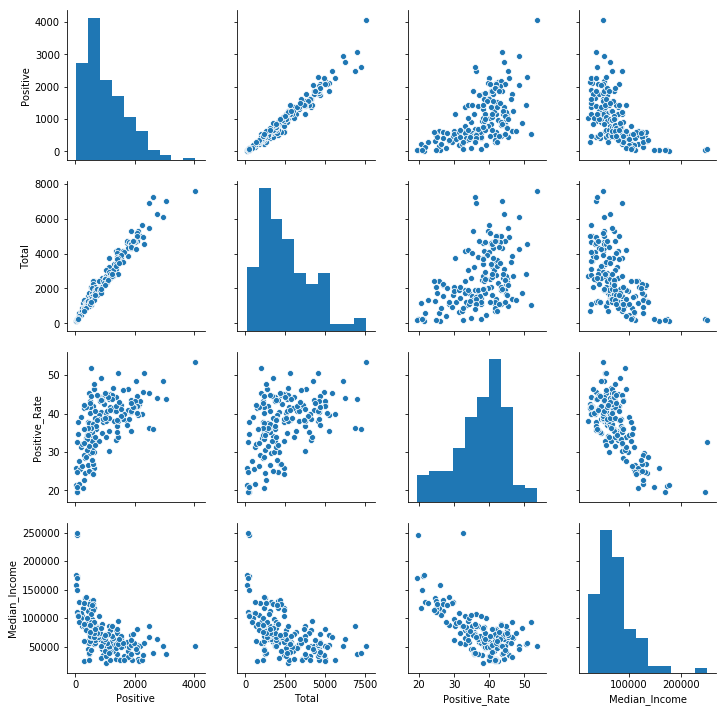

In [71]:
sns.pairplot(df_merge_population[['Positive','Total','Positive_Rate','Median_Income']])
plt.show()

Variable 'Positive' and 'Total' are skewed right. Thus, we need to normalize these variables by figuring the number of positive tests and total number of test per 1000 people.

In [36]:
#Calculate number of positive cases per 1000 people per Zip Code
df_merge_population ['Positive_per_1000']= 1000*df_merge_population ['Positive']/df_merge_population['Population']

#Calculate number of tests cases per 1000 people per Zip Code
df_merge_population ['Test_per_1000']= 1000*df_merge_population ['Total']/df_merge_population['Population']

df_merge_population.head()

,Zip_Code,Positive,Total,Positive_Rate,geoid,Median_Income,Population,Positive_per_1000,Test_per_1000
0,10001.0,321,1130,28.41,86000US10001,88526,22924,14.002792,49.293317
1,10002.0,931,2457,37.89,86000US10002,35859,74993,12.414492,32.763058
2,10003.0,414,1549,26.73,86000US10003,112131,54682,7.571047,28.327420
3,10004.0,28,108,25.93,86000US10004,157645,3028,9.247028,35.667107
4,10005.0,54,256,21.09,86000US10005,173333,8831,6.114823,28.988789


In [37]:
df_merge_population.head()

,Zip_Code,Positive,Total,Positive_Rate,geoid,Median_Income,Population,Positive_per_1000,Test_per_1000
0,10001.0,321,1130,28.41,86000US10001,88526,22924,14.002792,49.293317
1,10002.0,931,2457,37.89,86000US10002,35859,74993,12.414492,32.763058
2,10003.0,414,1549,26.73,86000US10003,112131,54682,7.571047,28.327420
3,10004.0,28,108,25.93,86000US10004,157645,3028,9.247028,35.667107
4,10005.0,54,256,21.09,86000US10005,173333,8831,6.114823,28.988789


In [38]:
df_merge_population.shape

(177, 9)

In [39]:
df_merge_population.describe()

,Zip_Code,Positive,Total,Positive_Rate,Median_Income,Population,Positive_per_1000,Test_per_1000
count,177.000000,177.000000,177.00000,177.000000,177.000000,177.000000,177.000000,177.000000
mean,10810.378531,1009.158192,2550.59322,37.558644,73674.022599,47645.062147,20.622217,53.496984
std,578.173317,717.179607,1613.21261,7.067315,36534.018798,26698.398778,8.067842,15.660637
min,10001.000000,23.000000,108.00000,19.520000,21149.000000,3028.000000,4.369139,22.378517
25%,10301.000000,478.000000,1279.00000,33.830000,50832.000000,27403.000000,14.129020,41.008505
50%,11109.000000,818.000000,2108.00000,38.630000,66483.000000,42653.000000,20.776292,52.192001
75%,11361.000000,1430.000000,3711.00000,42.220000,86742.000000,67094.000000,26.113146,64.481991
max,11697.000000,4054.000000,7588.00000,53.430000,250001.000000,112425.000000,42.265080,96.417330


Our final dataframe has in total of 177 rows and 9 columns.
- Zip_Code is a zip code in NYC
- Positive is total confirmed cases
- Total is a total COVID test done
- Positive rate is the rate of positive cases divided by the total test given
- Median_Income is a median income per zip code
- The population is population per zip code
- Positive_per_1000 is a number of confirmed cases per 1000 people in each zip code
- Test_per_1000 is a number of tests given per 1000 people in each zip code. 

In [40]:
df_merge_population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177 entries, 0 to 176
Data columns (total 9 columns):
Zip_Code             177 non-null float64
Positive             177 non-null int64
Total                177 non-null int64
Positive_Rate        177 non-null float64
geoid                177 non-null object
Median_Income        177 non-null int64
Population           177 non-null int64
Positive_per_1000    177 non-null float64
Test_per_1000        177 non-null float64
dtypes: float64(4), int64(4), object(1)
memory usage: 13.8+ KB


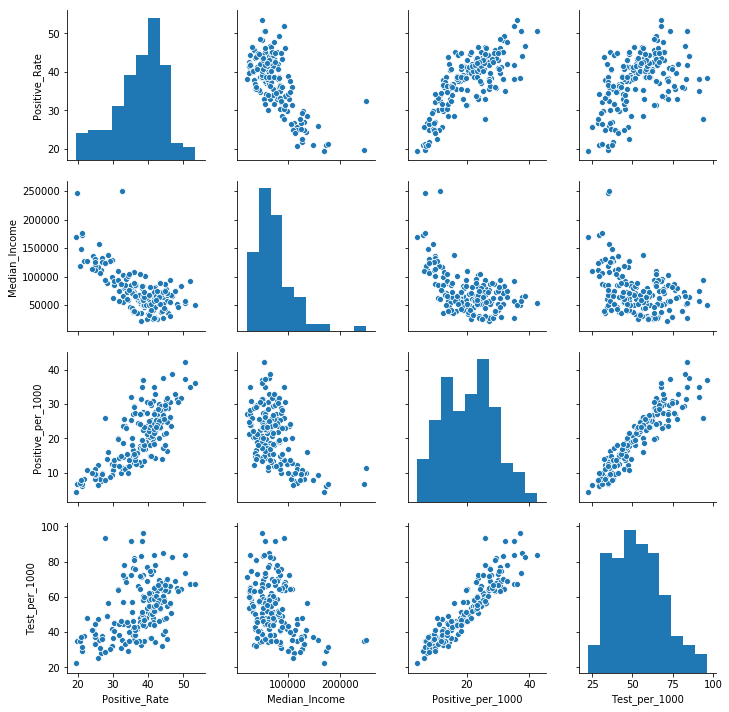

In [76]:
sns.pairplot(df_merge_population[['Positive_Rate','Median_Income','Positive_per_1000', 'Test_per_1000']])
plt.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Correlation between Median Income and Confirmed Cases per 1k')

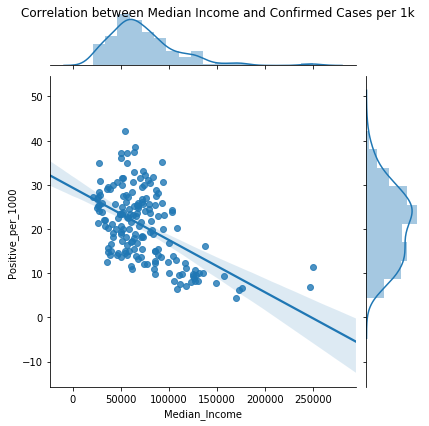

In [45]:
chart_positive_1000 = sns.jointplot(x='Median_Income', y='Positive_per_1000', data=df_merge_population, kind="reg")
chart_positive_1000.fig.suptitle('Correlation between Median Income and Confirmed Cases per 1k') 


Text(0.5, 0.98, 'Correlation between Median Income and Total Test per 1k')

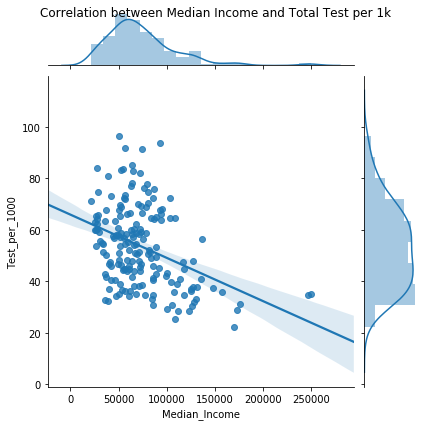

In [46]:
chart_test_1000 = sns.jointplot(x='Median_Income', y='Test_per_1000', data=df_merge_population, kind="reg")
chart_test_1000.fig.suptitle('Correlation between Median Income and Total Test per 1k') 


Text(0.5, 0.98, 'Correlation between Median Income and Positive Rate')

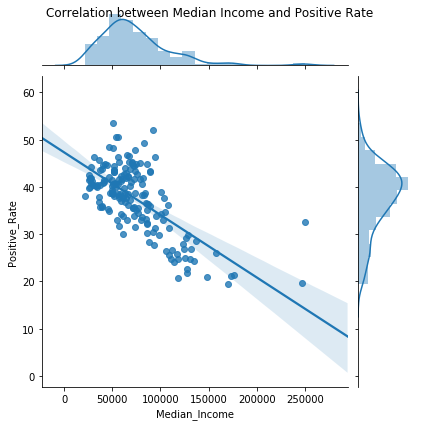

In [49]:
chart_Positive_Rate = sns.jointplot(x='Median_Income', y='Positive_Rate', data=df_merge, kind="reg")
chart_Positive_Rate.fig.suptitle('Correlation between Median Income and Positive Rate') 

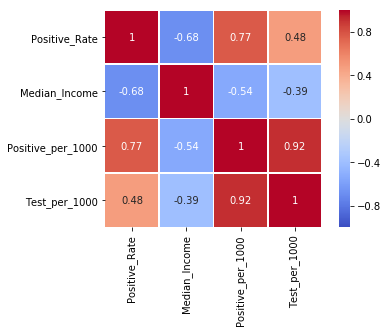

<Figure size 432x288 with 0 Axes>

In [51]:
df_merge_population_corr = df_merge_population.drop(['Zip_Code', 'Positive', 'Total', 'Population'], axis=1)
corrMatrix = df_merge_population_corr.corr()
sns.heatmap(corrMatrix, annot=True, linewidth = 0.5, cmap='coolwarm',square=True, vmin = -1, vmax = 1)
plt.show()
# plt.figure(figsize=(5,4))
plt.tight_layout()

When examining the relationship between median_income variable with number of positive test and total test, we can see the median income variable has a weak association with the number of tests are given and confirmed cases per 1000. However, median income does have a strong negative correlation with a positive rate. That means those who are tested and confirmed infected by the virus are more likely to live in lower-income areas.  This metric would raise concerns here as it is costly to access healthcare in the U.S. and low-income residents could possibly wait until the symptoms were severe before getting tested.

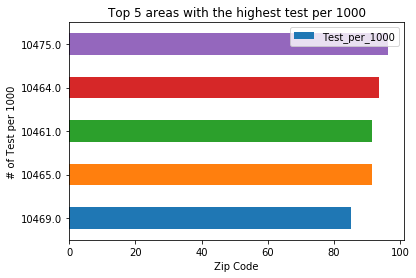

In [42]:
chart_top10_test = df_merge_population.sort_values(by=['Test_per_1000'])[-5:].plot(x="Zip_Code", y="Test_per_1000", kind="barh")
plt.title ("Top 5 areas with the highest test per 1000")
plt.ylabel ("# of Test per 1000")
plt.xlabel ("Zip Code")
plt.show()

The areas that have the highest number of COVID-19 tests per 1000 are in Northeast and Southeast Bronx neighborhoods.

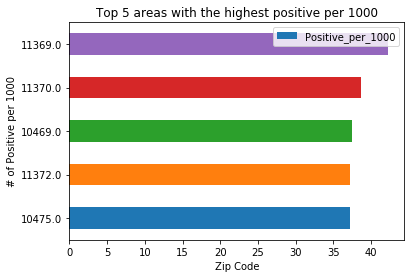

In [43]:
chart_top10_positive = df_merge_population.sort_values(by=['Positive_per_1000'])[-5:].plot(x="Zip_Code", y="Positive_per_1000", kind="barh")
plt.title ("Top 5 areas with the highest positive per 1000")
plt.ylabel ("# of Positive per 1000")
plt.xlabel ("Zip Code")
plt.show()

The areas that have highest number of positive COVID-19 test per 1000 are in Northeast Bronx and West Queens neighborhoods. Northese Bronx neighboorhood is also among one of the area that have the highest number of COVID-19 tests.

In [50]:
to_excel = df_merge_population.to_excel('clean.xlsx')

### Map

The best way to see data is to use visualization so I map out the areas that are have confirmed cases with the median income.

In [52]:
fp = "acs2018_5yr_B19001_86000US10543.shp"
map_df = gpd.read_file(fp)
# check the GeoDataframe
map_df.head()

,geoid,name,B19001001,B19001001e,B19001002,B19001002e,B19001003,B19001003e,B19001004,B19001004e,...,B19001013e,B19001014,B19001014e,B19001015,B19001015e,B19001016,B19001016e,B19001017,B19001017e,geometry
0,01000US,United States,119730128.0,232429.0,7584305.0,18464.0,5507051.0,15243.0,5488289.0,17043.0,...,47276.0,10600942.0,51888.0,6932183.0,35577.0,7513313.0,42617.0,8355566.0,47620.0,"(POLYGON ((-168.225273 -14.535906, -168.199527..."
1,04000US36,New York,7316537.0,13711.0,492408.0,5214.0,378399.0,3977.0,325767.0,4093.0,...,7268.0,658357.0,5530.0,466265.0,5399.0,554471.0,5334.0,712800.0,7070.0,"(POLYGON ((-79.312136 42.686805, -79.249765999..."
2,86000US06390,06390,73.0,45.0,0.0,12.0,2.0,3.0,0.0,12.0,...,12.0,6.0,6.0,0.0,12.0,21.0,30.0,7.0,7.0,"(POLYGON ((-72.00941899999999 41.285283, -72.0..."
3,86000US07421,07421,2637.0,164.0,50.0,53.0,35.0,32.0,32.0,37.0,...,112.0,315.0,112.0,263.0,103.0,391.0,121.0,226.0,87.0,"(POLYGON ((-74.331046 41.186667, -74.331017 41..."
4,86000US10001,10001,12431.0,521.0,1096.0,324.0,488.0,168.0,494.0,175.0,...,235.0,1063.0,266.0,873.0,210.0,945.0,197.0,2797.0,350.0,"POLYGON ((-74.00828 40.750272, -74.007829 40.7..."


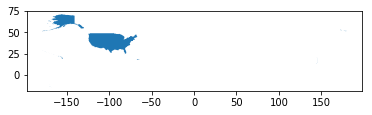

In [53]:
map_df.plot()

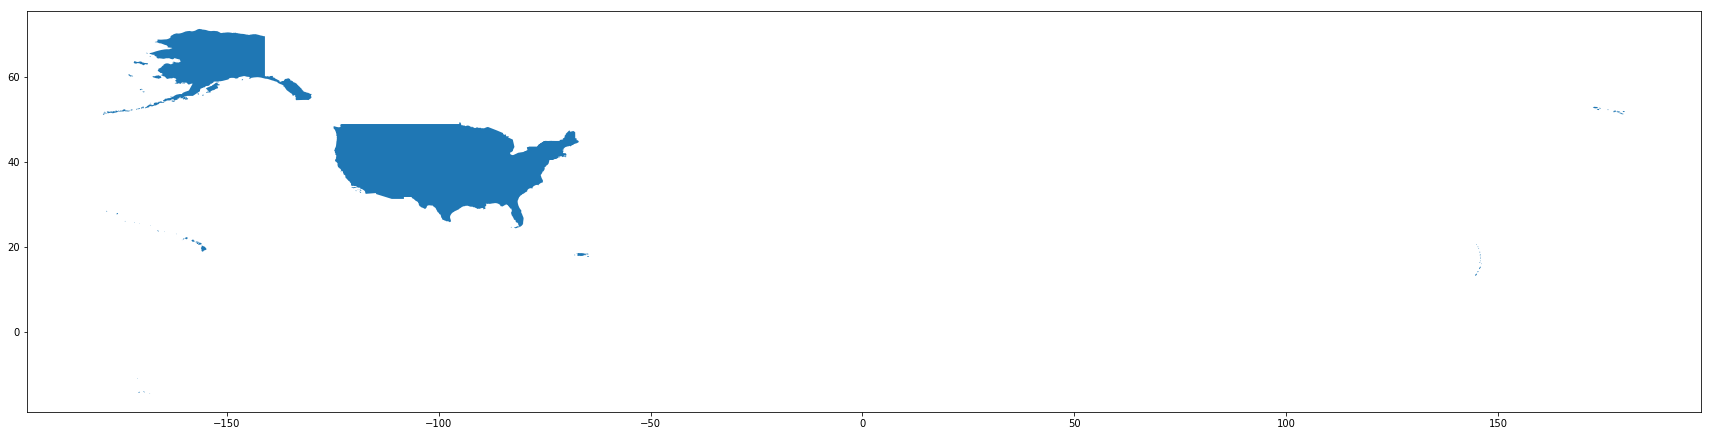

In [54]:
plt.rcParams['figure.figsize'] = [30, 90] #height, width
map_df.plot()

In [55]:
# join the geodataframe with the csv dataframe
merged = map_df.merge(df_merge_population, how='left', on="geoid")

merged.head()

,geoid,name,B19001001,B19001001e,B19001002,B19001002e,B19001003,B19001003e,B19001004,B19001004e,...,B19001017e,geometry,Zip_Code,Positive,Total,Positive_Rate,Median_Income,Population,Positive_per_1000,Test_per_1000
0,01000US,United States,119730128.0,232429.0,7584305.0,18464.0,5507051.0,15243.0,5488289.0,17043.0,...,47620.0,"(POLYGON ((-168.225273 -14.535906, -168.199527...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04000US36,New York,7316537.0,13711.0,492408.0,5214.0,378399.0,3977.0,325767.0,4093.0,...,7070.0,"(POLYGON ((-79.312136 42.686805, -79.249765999...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,86000US06390,06390,73.0,45.0,0.0,12.0,2.0,3.0,0.0,12.0,...,7.0,"(POLYGON ((-72.00941899999999 41.285283, -72.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,86000US07421,07421,2637.0,164.0,50.0,53.0,35.0,32.0,32.0,37.0,...,87.0,"(POLYGON ((-74.331046 41.186667, -74.331017 41...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,86000US10001,10001,12431.0,521.0,1096.0,324.0,488.0,168.0,494.0,175.0,...,350.0,"POLYGON ((-74.00828 40.750272, -74.007829 40.7...",10001.0,321.0,1130.0,28.41,88526.0,22924.0,14.002792,49.293317


In [56]:
to_excel = merged.to_excel('final.xlsx')

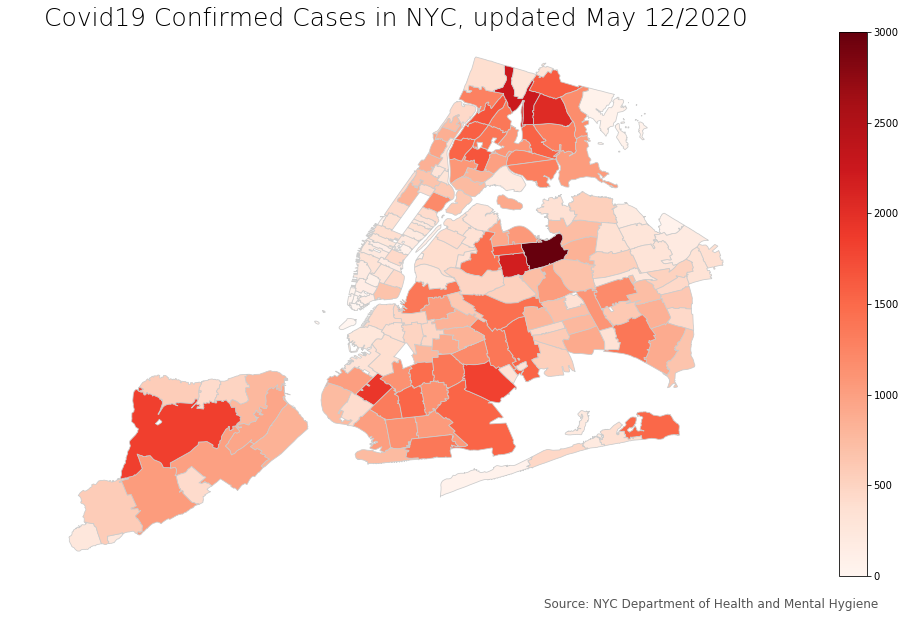

In [57]:
# set the value column that will be visualised
variable = 'Positive'
# set the range for the choropleth values
vmin, vmax = 0, 3000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Covid19 Confirmed Cases in NYC, updated May 12/2020', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: NYC Department of Health and Mental Hygiene', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

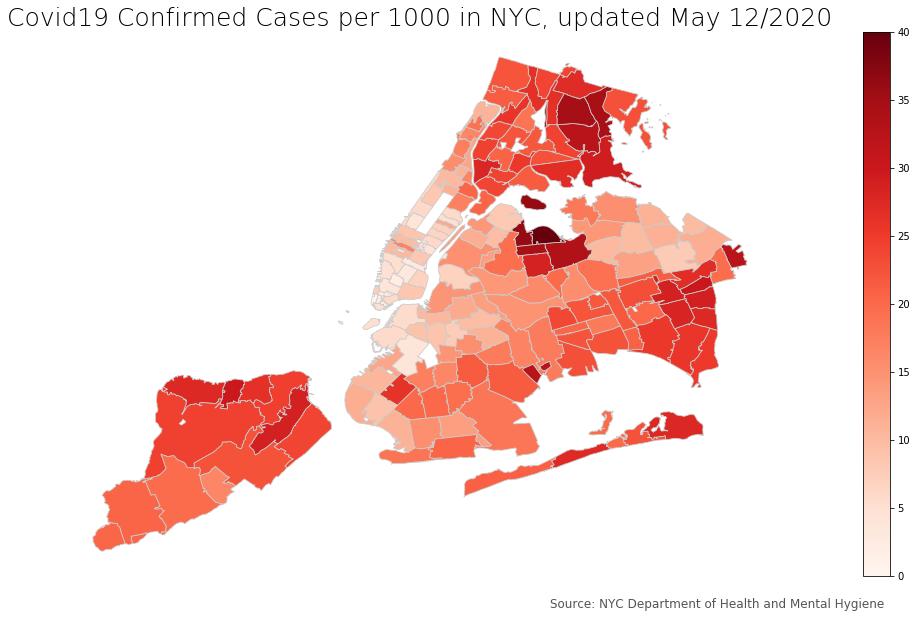

In [58]:
# set the value column that will be visualised
variable = 'Positive_per_1000'
# set the range for the choropleth values
vmin, vmax = 0, 40
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Covid19 Confirmed Cases per 1000 in NYC, updated May 12/2020', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: NYC Department of Health and Mental Hygiene', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

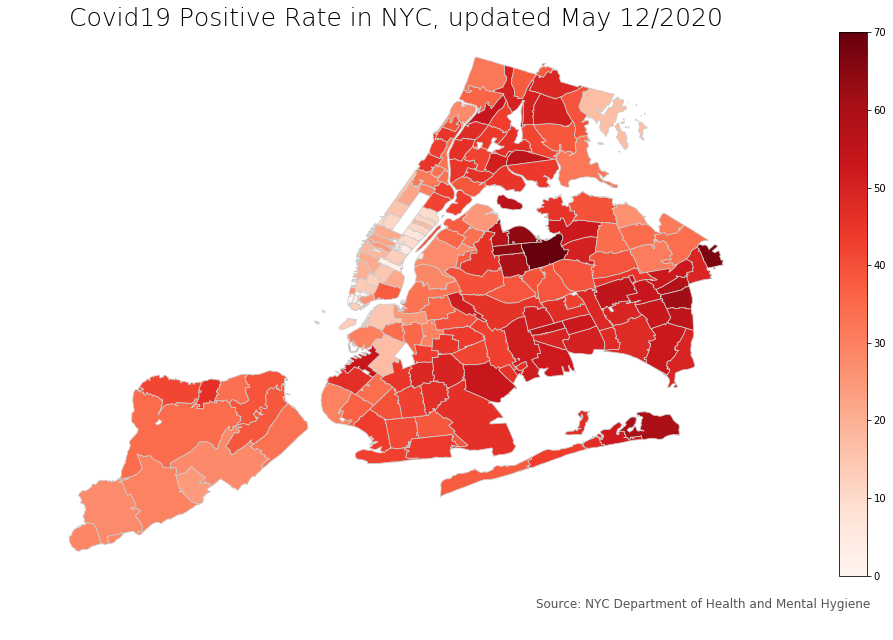

In [59]:
# set the value column that will be visualised
variable = 'Positive_Rate'
# set the range for the choropleth values
vmin, vmax = 0, 70
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Covid19 Positive Rate in NYC, updated May 12/2020', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: NYC Department of Health and Mental Hygiene', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Reds', linewidth=0.8, ax=ax, edgecolor='0.8')

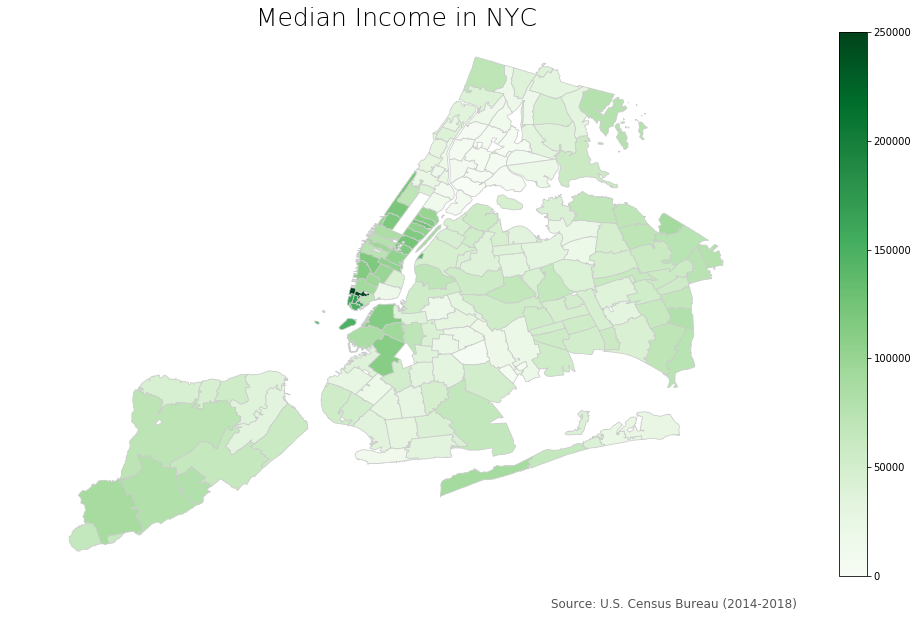

In [60]:
# set the value column that will be visualised
variable = 'Median_Income'
# set the range for the choropleth values
vmin, vmax = 0, 250000
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(30, 10))
# remove the axis
ax.axis('off')
# add a title and annotation
ax.set_title('Median Income in NYC', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: U.S. Census Bureau (2014-2018)', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
# add the colorbar to the figure
fig.colorbar(sm)
# create map
merged.plot(column=variable, cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8')

## Conclusion

The data about confirmed cases based on median income in each zip code alone does not give us enough evidence proving that COVID-19 cases mostly affect low-income areas. Knowing how rapidly the virus spreads in the community, we would need more data such as employment status, change of commuting or ridership before and after the pandemic, household size to justify whether low-income neighbourhoods are more vulnerable to this virus. 